# Model Performance Test


In [1]:
from dtsp.dataset import walk_forward_split, Seq2SeqDataSet, SimpleSeq2SeqDataSet, SimpleWaveNetDataSet
from dtsp.models import Seq2Seq, SimpleSeq2Seq, SimpleWaveNet
from torch.utils.data import DataLoader
from torch.utils.data import Subset, DataLoader
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from pathlib import Path
import shutil
import seaborn as sns

%matplotlib inline

def plot_attentions(attns):
    if attns.ndim == 4:
        assert attns.shape[0] == 1
        attns = attns.squeeze(0)
    if isinstance(attns, torch.Tensor):
        attns = attns.detach().numpy()
    n_head = attns.shape[1]
    
    base_size = 12
    
    hight = attns.shape[0]
    wide = attns.shape[2]
    for i in range(n_head):
        plt.figure(figsize=(16, hight / wide * 16))
        sns.heatmap(attns[:, i, :])
        plt.title(f"Attention {i}")
        plt.xlabel('history')
        plt.ylabel('prediction')


def plot_prediction(enc, y_pred, y_true):
    f = plt.figure(figsize=(12, 4))
    enc_lens = len(enc)
    dec_lens = len(y_pred)
    plt.plot(enc)
    plt.plot(range(enc_lens, enc_lens+dec_lens), y_pred, label='prediction', linestyle='--')
    plt.plot(range(enc_lens, enc_lens+dec_lens), y_true, label='true')
    plt.legend()

In [2]:
torch.__version__

'1.3.0'

## 1. prepare dataset

In [3]:
df = pd.read_csv('./data.csv', index_col='date_time', parse_dates=['date_time'])
series = df.values
month = df.index.month.values
df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
date_time,,,,,,,,,,,,,,,,,,,,
1998-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0


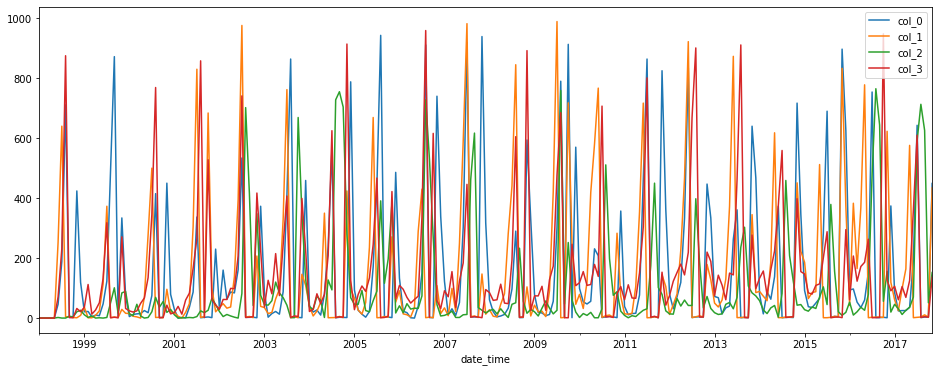

In [4]:
df.iloc[:, :4].plot(figsize=(16, 6))

**Target**

In [5]:
n_test = 12
n_val = 12
enc_lens = 72
dec_lens = 12
batch_size = 8
epochs = 50

## 1. Simple Seq2Seq Model

In [23]:
dataset = SimpleSeq2SeqDataSet(series, enc_lens, dec_lens)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [24]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.2,
        'hidden_size': 72,
        'teacher_forcing_rate': 0.5,
        'learning_rate': 0.001,
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = SimpleSeq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.980: 100%|██████████| 17/17 [00:00<00:00, 20.79it/s]


epoch 1 / 50: train loss 1.050 val loss 1.190 RMSE 181.258
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.845: 100%|██████████| 17/17 [00:00<00:00, 19.15it/s]


epoch 2 / 50: train loss 0.942 val loss 0.993 RMSE 169.968


batch 17 / 17, loss 0.820: 100%|██████████| 17/17 [00:00<00:00, 20.08it/s]


epoch 3 / 50: train loss 0.820 val loss 0.960 RMSE 166.055


batch 17 / 17, loss 0.932: 100%|██████████| 17/17 [00:00<00:00, 20.49it/s]


epoch 4 / 50: train loss 0.808 val loss 0.937 RMSE 164.511


batch 17 / 17, loss 0.809: 100%|██████████| 17/17 [00:00<00:00, 20.86it/s]


epoch 5 / 50: train loss 0.787 val loss 0.935 RMSE 164.318


batch 17 / 17, loss 0.934: 100%|██████████| 17/17 [00:00<00:00, 18.96it/s]


epoch 6 / 50: train loss 0.777 val loss 0.935 RMSE 162.984


batch 17 / 17, loss 0.650: 100%|██████████| 17/17 [00:00<00:00, 20.20it/s]


epoch 7 / 50: train loss 0.732 val loss 0.859 RMSE 155.444


batch 17 / 17, loss 0.680: 100%|██████████| 17/17 [00:00<00:00, 19.77it/s]


epoch 8 / 50: train loss 0.696 val loss 0.848 RMSE 154.758


batch 17 / 17, loss 0.570: 100%|██████████| 17/17 [00:00<00:00, 20.61it/s]


epoch 9 / 50: train loss 0.670 val loss 0.837 RMSE 153.705


batch 17 / 17, loss 0.589: 100%|██████████| 17/17 [00:00<00:00, 19.55it/s]


epoch 10 / 50: train loss 0.680 val loss 0.849 RMSE 155.316


batch 17 / 17, loss 0.677: 100%|██████████| 17/17 [00:00<00:00, 19.82it/s]


epoch 11 / 50: train loss 0.650 val loss 0.808 RMSE 150.322


batch 17 / 17, loss 0.681: 100%|██████████| 17/17 [00:00<00:00, 19.33it/s]


epoch 12 / 50: train loss 0.634 val loss 0.817 RMSE 150.648


batch 17 / 17, loss 0.623: 100%|██████████| 17/17 [00:00<00:00, 18.79it/s]


epoch 13 / 50: train loss 0.649 val loss 0.870 RMSE 155.498


batch 17 / 17, loss 0.733: 100%|██████████| 17/17 [00:00<00:00, 17.50it/s]


epoch 14 / 50: train loss 0.643 val loss 0.787 RMSE 147.421


batch 17 / 17, loss 0.615: 100%|██████████| 17/17 [00:00<00:00, 18.45it/s]


epoch 15 / 50: train loss 0.609 val loss 0.778 RMSE 146.388


batch 17 / 17, loss 0.590: 100%|██████████| 17/17 [00:00<00:00, 19.98it/s]


epoch 16 / 50: train loss 0.595 val loss 0.775 RMSE 145.835


batch 17 / 17, loss 0.689: 100%|██████████| 17/17 [00:00<00:00, 20.10it/s]


epoch 17 / 50: train loss 0.577 val loss 0.762 RMSE 144.709


batch 17 / 17, loss 0.586: 100%|██████████| 17/17 [00:00<00:00, 20.03it/s]


epoch 18 / 50: train loss 0.573 val loss 0.813 RMSE 150.661


batch 17 / 17, loss 0.630: 100%|██████████| 17/17 [00:00<00:00, 20.03it/s]


epoch 19 / 50: train loss 0.565 val loss 0.797 RMSE 149.152


batch 17 / 17, loss 0.585: 100%|██████████| 17/17 [00:00<00:00, 20.17it/s]


epoch 20 / 50: train loss 0.555 val loss 0.755 RMSE 144.340


batch 17 / 17, loss 0.492: 100%|██████████| 17/17 [00:00<00:00, 20.62it/s]


epoch 21 / 50: train loss 0.529 val loss 0.740 RMSE 142.812


batch 17 / 17, loss 0.494: 100%|██████████| 17/17 [00:00<00:00, 20.20it/s]


epoch 22 / 50: train loss 0.526 val loss 0.736 RMSE 142.389


batch 17 / 17, loss 0.501: 100%|██████████| 17/17 [00:00<00:00, 20.39it/s]


epoch 23 / 50: train loss 0.518 val loss 0.722 RMSE 141.230


batch 17 / 17, loss 0.559: 100%|██████████| 17/17 [00:00<00:00, 19.82it/s]


epoch 24 / 50: train loss 0.532 val loss 0.743 RMSE 143.153


batch 17 / 17, loss 0.401: 100%|██████████| 17/17 [00:00<00:00, 19.46it/s]


epoch 25 / 50: train loss 0.534 val loss 0.721 RMSE 140.465


batch 17 / 17, loss 0.495: 100%|██████████| 17/17 [00:00<00:00, 19.50it/s]


epoch 26 / 50: train loss 0.524 val loss 0.723 RMSE 141.711


batch 17 / 17, loss 0.505: 100%|██████████| 17/17 [00:00<00:00, 19.55it/s]


epoch 27 / 50: train loss 0.502 val loss 0.712 RMSE 140.106


batch 17 / 17, loss 0.414: 100%|██████████| 17/17 [00:00<00:00, 20.37it/s]


epoch 28 / 50: train loss 0.480 val loss 0.701 RMSE 138.778


batch 17 / 17, loss 0.557: 100%|██████████| 17/17 [00:00<00:00, 19.55it/s]


epoch 29 / 50: train loss 0.478 val loss 0.697 RMSE 137.952


batch 17 / 17, loss 0.461: 100%|██████████| 17/17 [00:00<00:00, 20.74it/s]


epoch 30 / 50: train loss 0.463 val loss 0.707 RMSE 139.788


batch 17 / 17, loss 0.436: 100%|██████████| 17/17 [00:00<00:00, 19.41it/s]


epoch 31 / 50: train loss 0.478 val loss 0.690 RMSE 137.459


batch 17 / 17, loss 0.420: 100%|██████████| 17/17 [00:00<00:00, 20.28it/s]


epoch 32 / 50: train loss 0.468 val loss 0.682 RMSE 136.453


batch 17 / 17, loss 0.590: 100%|██████████| 17/17 [00:00<00:00, 19.84it/s]


epoch 33 / 50: train loss 0.466 val loss 0.679 RMSE 136.305


batch 17 / 17, loss 0.598: 100%|██████████| 17/17 [00:00<00:00, 20.15it/s]


epoch 34 / 50: train loss 0.469 val loss 0.669 RMSE 134.382


batch 17 / 17, loss 0.397: 100%|██████████| 17/17 [00:00<00:00, 20.46it/s]


epoch 35 / 50: train loss 0.451 val loss 0.676 RMSE 136.107


batch 17 / 17, loss 0.369: 100%|██████████| 17/17 [00:00<00:00, 20.27it/s]


epoch 36 / 50: train loss 0.451 val loss 0.668 RMSE 134.664


batch 17 / 17, loss 0.442: 100%|██████████| 17/17 [00:00<00:00, 19.87it/s]


epoch 37 / 50: train loss 0.442 val loss 0.669 RMSE 134.555


batch 17 / 17, loss 0.480: 100%|██████████| 17/17 [00:00<00:00, 19.20it/s]


epoch 38 / 50: train loss 0.460 val loss 0.664 RMSE 134.004


batch 17 / 17, loss 0.441: 100%|██████████| 17/17 [00:00<00:00, 20.05it/s]


epoch 39 / 50: train loss 0.438 val loss 0.657 RMSE 133.175


batch 17 / 17, loss 0.391: 100%|██████████| 17/17 [00:00<00:00, 19.50it/s]


epoch 40 / 50: train loss 0.451 val loss 0.660 RMSE 134.015


batch 17 / 17, loss 0.400: 100%|██████████| 17/17 [00:00<00:00, 19.39it/s]


epoch 41 / 50: train loss 0.448 val loss 0.657 RMSE 133.291


batch 17 / 17, loss 0.354: 100%|██████████| 17/17 [00:00<00:00, 19.87it/s]


epoch 42 / 50: train loss 0.439 val loss 0.655 RMSE 132.930


batch 17 / 17, loss 0.507: 100%|██████████| 17/17 [00:00<00:00, 20.74it/s]


epoch 43 / 50: train loss 0.429 val loss 0.655 RMSE 132.799


batch 17 / 17, loss 0.441: 100%|██████████| 17/17 [00:00<00:00, 19.39it/s]


epoch 44 / 50: train loss 0.440 val loss 0.650 RMSE 132.645


batch 17 / 17, loss 0.421: 100%|██████████| 17/17 [00:00<00:00, 19.89it/s]


epoch 45 / 50: train loss 0.438 val loss 0.648 RMSE 132.160


batch 17 / 17, loss 0.364: 100%|██████████| 17/17 [00:00<00:00, 20.27it/s]


epoch 46 / 50: train loss 0.420 val loss 0.646 RMSE 131.892


batch 17 / 17, loss 0.444: 100%|██████████| 17/17 [00:00<00:00, 20.41it/s]


epoch 47 / 50: train loss 0.419 val loss 0.645 RMSE 131.806


batch 17 / 17, loss 0.480: 100%|██████████| 17/17 [00:00<00:00, 20.13it/s]


epoch 48 / 50: train loss 0.430 val loss 0.645 RMSE 131.835


batch 17 / 17, loss 0.417: 100%|██████████| 17/17 [00:00<00:00, 20.05it/s]


epoch 49 / 50: train loss 0.416 val loss 0.644 RMSE 131.699


batch 17 / 17, loss 0.455: 100%|██████████| 17/17 [00:00<00:00, 20.13it/s]


epoch 50 / 50: train loss 0.431 val loss 0.645 RMSE 131.917
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\SimpleSeq2Seq_epoch_49_0.644.pkl


In [25]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.447, valid loss: 0.644, test loss :0.699, test RMSE :137.596, 


Text(0.5, 1.0, 'Simple Seq2Seq prediction')

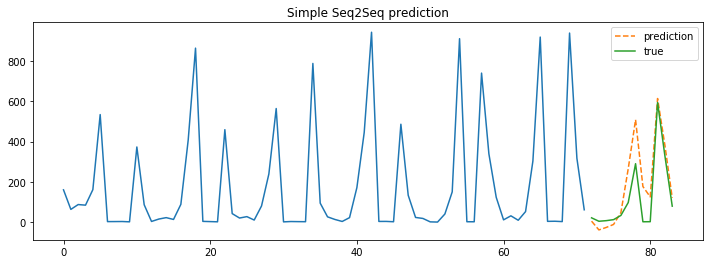

In [26]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Simple Seq2Seq prediction')

## 2. Seq2Seq(Attention 0)

In [7]:
dataset = Seq2SeqDataSet(series, enc_lens, dec_lens, categorical_var=month)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [7]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 4,
        'use_attn': False,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.817: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.58it/s]


epoch 1 / 50: train loss 1.051 val loss 1.142 RMSE 178.177
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.773: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.12it/s]


epoch 2 / 50: train loss 0.845 val loss 0.964 RMSE 166.053


batch 17 / 17, loss 0.708: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.84it/s]


epoch 3 / 50: train loss 0.782 val loss 0.899 RMSE 160.739


batch 17 / 17, loss 0.638: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.90it/s]


epoch 4 / 50: train loss 0.736 val loss 0.870 RMSE 157.403


batch 17 / 17, loss 0.577: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.03it/s]


epoch 5 / 50: train loss 0.705 val loss 0.864 RMSE 156.647


batch 17 / 17, loss 0.967: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.93it/s]


epoch 6 / 50: train loss 0.732 val loss 1.061 RMSE 175.502


batch 17 / 17, loss 0.761: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.08it/s]


epoch 7 / 50: train loss 0.758 val loss 0.891 RMSE 157.343


batch 17 / 17, loss 0.647: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.00it/s]


epoch 8 / 50: train loss 0.680 val loss 0.835 RMSE 152.800


batch 17 / 17, loss 0.492: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.19it/s]


epoch 9 / 50: train loss 0.644 val loss 0.810 RMSE 149.951


batch 17 / 17, loss 0.546: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.05it/s]


epoch 10 / 50: train loss 0.624 val loss 0.809 RMSE 150.340


batch 17 / 17, loss 0.776: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.53it/s]


epoch 11 / 50: train loss 0.637 val loss 0.773 RMSE 146.472


batch 17 / 17, loss 0.451: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.11it/s]


epoch 12 / 50: train loss 0.586 val loss 0.774 RMSE 146.156


batch 17 / 17, loss 0.496: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.20it/s]


epoch 13 / 50: train loss 0.561 val loss 0.756 RMSE 146.384


batch 17 / 17, loss 0.524: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.89it/s]


epoch 14 / 50: train loss 0.561 val loss 0.737 RMSE 142.661


batch 17 / 17, loss 0.444: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.92it/s]


epoch 15 / 50: train loss 0.537 val loss 0.757 RMSE 145.427


batch 17 / 17, loss 0.625: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.70it/s]


epoch 16 / 50: train loss 0.533 val loss 0.731 RMSE 143.180


batch 17 / 17, loss 0.451: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.14it/s]


epoch 17 / 50: train loss 0.507 val loss 0.750 RMSE 146.235


batch 17 / 17, loss 0.452: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.97it/s]


epoch 18 / 50: train loss 0.491 val loss 0.718 RMSE 141.187


batch 17 / 17, loss 0.530: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.91it/s]


epoch 19 / 50: train loss 0.465 val loss 0.696 RMSE 138.917


batch 17 / 17, loss 0.442: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.78it/s]


epoch 20 / 50: train loss 0.453 val loss 0.741 RMSE 145.557


batch 17 / 17, loss 0.378: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.71it/s]


epoch 21 / 50: train loss 0.514 val loss 0.754 RMSE 146.057


batch 17 / 17, loss 0.354: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.61it/s]


epoch 22 / 50: train loss 0.484 val loss 0.712 RMSE 139.977


batch 17 / 17, loss 0.509: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.80it/s]


epoch 23 / 50: train loss 0.463 val loss 0.677 RMSE 136.207


batch 17 / 17, loss 0.331: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.31it/s]


epoch 24 / 50: train loss 0.433 val loss 0.670 RMSE 136.320


batch 17 / 17, loss 0.332: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.28it/s]


epoch 25 / 50: train loss 0.411 val loss 0.664 RMSE 136.110


batch 17 / 17, loss 0.325: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.96it/s]


epoch 26 / 50: train loss 0.407 val loss 0.698 RMSE 139.874


batch 17 / 17, loss 0.306: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.09it/s]


epoch 27 / 50: train loss 0.406 val loss 0.634 RMSE 131.122


batch 17 / 17, loss 0.378: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.12it/s]


epoch 28 / 50: train loss 0.369 val loss 0.628 RMSE 131.774


batch 17 / 17, loss 0.289: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.26it/s]


epoch 29 / 50: train loss 0.369 val loss 0.601 RMSE 127.115


batch 17 / 17, loss 0.290: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.44it/s]


epoch 30 / 50: train loss 0.352 val loss 0.607 RMSE 127.894


batch 17 / 17, loss 0.312: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.03it/s]


epoch 31 / 50: train loss 0.351 val loss 0.588 RMSE 125.147


batch 17 / 17, loss 0.373: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.40it/s]


epoch 32 / 50: train loss 0.346 val loss 0.581 RMSE 124.177


batch 17 / 17, loss 0.291: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.86it/s]


epoch 33 / 50: train loss 0.345 val loss 0.579 RMSE 124.025


batch 17 / 17, loss 0.280: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.90it/s]


epoch 34 / 50: train loss 0.341 val loss 0.562 RMSE 121.154


batch 17 / 17, loss 0.288: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.74it/s]


epoch 35 / 50: train loss 0.331 val loss 0.557 RMSE 120.070


batch 17 / 17, loss 0.291: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.54it/s]


epoch 36 / 50: train loss 0.318 val loss 0.562 RMSE 120.824


batch 17 / 17, loss 0.269: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.81it/s]


epoch 37 / 50: train loss 0.300 val loss 0.549 RMSE 119.318


batch 17 / 17, loss 0.439: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.05it/s]


epoch 38 / 50: train loss 0.321 val loss 0.541 RMSE 118.049


batch 17 / 17, loss 0.341: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.92it/s]


epoch 39 / 50: train loss 0.314 val loss 0.537 RMSE 117.338


batch 17 / 17, loss 0.304: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.17it/s]


epoch 40 / 50: train loss 0.299 val loss 0.534 RMSE 116.679


batch 17 / 17, loss 0.339: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 41 / 50: train loss 0.293 val loss 0.530 RMSE 115.845


batch 17 / 17, loss 0.256: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.25it/s]


epoch 42 / 50: train loss 0.280 val loss 0.528 RMSE 115.604


batch 17 / 17, loss 0.310: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.71it/s]


epoch 43 / 50: train loss 0.287 val loss 0.525 RMSE 115.026


batch 17 / 17, loss 0.288: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.52it/s]


epoch 44 / 50: train loss 0.287 val loss 0.523 RMSE 114.841


batch 17 / 17, loss 0.283: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.14it/s]


epoch 45 / 50: train loss 0.278 val loss 0.520 RMSE 114.335


batch 17 / 17, loss 0.244: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.89it/s]


epoch 46 / 50: train loss 0.283 val loss 0.517 RMSE 113.948


batch 17 / 17, loss 0.328: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.64it/s]


epoch 47 / 50: train loss 0.288 val loss 0.516 RMSE 113.797


batch 17 / 17, loss 0.303: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.56it/s]


epoch 48 / 50: train loss 0.257 val loss 0.518 RMSE 114.219


batch 17 / 17, loss 0.227: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.15it/s]


epoch 49 / 50: train loss 0.274 val loss 0.517 RMSE 113.942


batch 17 / 17, loss 0.281: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.67it/s]


epoch 50 / 50: train loss 0.267 val loss 0.516 RMSE 113.813
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_46_0.517.pkl


In [29]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.304, valid loss: 0.512, test loss :0.581, test RMSE :123.280, 


Text(0.5, 1.0, 'Seq2Seq 0 Attention prediction')

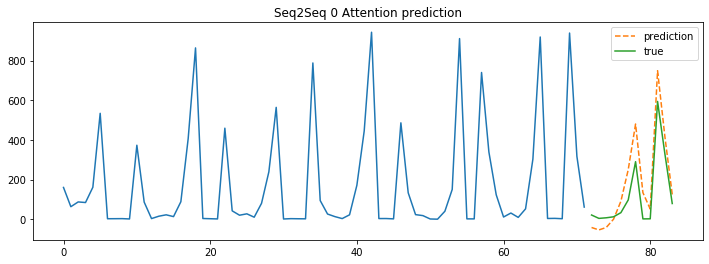

In [30]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Seq2Seq 0 Attention prediction')

## 3. Seq2Seq(Attention 1)

In [31]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 1,
        'use_attn': True,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 1.022: 100%|██████████| 17/17 [00:02<00:00,  7.60it/s]


epoch 1 / 50: train loss 1.071 val loss 1.180 RMSE 180.460
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.888: 100%|██████████| 17/17 [00:02<00:00,  7.69it/s]


epoch 2 / 50: train loss 0.926 val loss 0.962 RMSE 166.658


batch 17 / 17, loss 0.812: 100%|██████████| 17/17 [00:02<00:00,  7.50it/s]


epoch 3 / 50: train loss 0.832 val loss 0.934 RMSE 164.780


batch 17 / 17, loss 1.082: 100%|██████████| 17/17 [00:02<00:00,  7.53it/s]


epoch 4 / 50: train loss 0.804 val loss 0.914 RMSE 163.136


batch 17 / 17, loss 0.615: 100%|██████████| 17/17 [00:02<00:00,  7.60it/s]


epoch 5 / 50: train loss 0.775 val loss 0.912 RMSE 162.801


batch 17 / 17, loss 0.666: 100%|██████████| 17/17 [00:02<00:00,  7.85it/s]


epoch 6 / 50: train loss 0.721 val loss 0.848 RMSE 155.015


batch 17 / 17, loss 0.716: 100%|██████████| 17/17 [00:02<00:00,  7.64it/s]


epoch 7 / 50: train loss 0.697 val loss 0.814 RMSE 151.236


batch 17 / 17, loss 0.589: 100%|██████████| 17/17 [00:02<00:00,  7.67it/s]


epoch 8 / 50: train loss 0.664 val loss 0.795 RMSE 148.914


batch 17 / 17, loss 0.606: 100%|██████████| 17/17 [00:02<00:00,  7.68it/s]


epoch 9 / 50: train loss 0.629 val loss 0.812 RMSE 153.360


batch 17 / 17, loss 0.934: 100%|██████████| 17/17 [00:02<00:00,  7.66it/s]


epoch 10 / 50: train loss 0.649 val loss 0.923 RMSE 161.343


batch 17 / 17, loss 0.701: 100%|██████████| 17/17 [00:02<00:00,  7.70it/s]


epoch 11 / 50: train loss 0.625 val loss 0.753 RMSE 146.265


batch 17 / 17, loss 0.447: 100%|██████████| 17/17 [00:02<00:00,  7.84it/s]


epoch 12 / 50: train loss 0.558 val loss 0.756 RMSE 147.058


batch 17 / 17, loss 0.575: 100%|██████████| 17/17 [00:02<00:00,  7.95it/s]


epoch 13 / 50: train loss 0.527 val loss 0.717 RMSE 142.573


batch 17 / 17, loss 0.648: 100%|██████████| 17/17 [00:02<00:00,  7.63it/s]


epoch 14 / 50: train loss 0.534 val loss 0.731 RMSE 143.565


batch 17 / 17, loss 0.489: 100%|██████████| 17/17 [00:02<00:00,  7.81it/s]


epoch 15 / 50: train loss 0.500 val loss 0.704 RMSE 141.850


batch 17 / 17, loss 0.516: 100%|██████████| 17/17 [00:02<00:00,  7.68it/s]


epoch 16 / 50: train loss 0.495 val loss 0.698 RMSE 139.742


batch 17 / 17, loss 0.406: 100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


epoch 17 / 50: train loss 0.454 val loss 0.672 RMSE 137.975


batch 17 / 17, loss 0.432: 100%|██████████| 17/17 [00:02<00:00,  7.63it/s]


epoch 18 / 50: train loss 0.464 val loss 0.683 RMSE 139.270


batch 17 / 17, loss 0.452: 100%|██████████| 17/17 [00:02<00:00,  7.62it/s]


epoch 19 / 50: train loss 0.453 val loss 0.651 RMSE 134.476


batch 17 / 17, loss 0.445: 100%|██████████| 17/17 [00:02<00:00,  7.57it/s]


epoch 20 / 50: train loss 0.436 val loss 0.627 RMSE 131.236


batch 17 / 17, loss 0.371: 100%|██████████| 17/17 [00:02<00:00,  7.83it/s]


epoch 21 / 50: train loss 0.418 val loss 0.615 RMSE 129.996


batch 17 / 17, loss 0.387: 100%|██████████| 17/17 [00:02<00:00,  7.81it/s]


epoch 22 / 50: train loss 0.390 val loss 0.641 RMSE 133.563


batch 17 / 17, loss 0.424: 100%|██████████| 17/17 [00:02<00:00,  7.76it/s]


epoch 23 / 50: train loss 0.389 val loss 0.598 RMSE 127.480


batch 17 / 17, loss 0.307: 100%|██████████| 17/17 [00:02<00:00,  7.77it/s]


epoch 24 / 50: train loss 0.377 val loss 0.616 RMSE 131.270


batch 17 / 17, loss 0.300: 100%|██████████| 17/17 [00:02<00:00,  7.84it/s]


epoch 25 / 50: train loss 0.368 val loss 0.594 RMSE 126.970


batch 17 / 17, loss 0.309: 100%|██████████| 17/17 [00:02<00:00,  7.80it/s]


epoch 26 / 50: train loss 0.351 val loss 0.574 RMSE 124.678


batch 17 / 17, loss 0.278: 100%|██████████| 17/17 [00:02<00:00,  7.55it/s]


epoch 27 / 50: train loss 0.348 val loss 0.549 RMSE 120.690


batch 17 / 17, loss 0.268: 100%|██████████| 17/17 [00:02<00:00,  7.84it/s]


epoch 28 / 50: train loss 0.314 val loss 0.538 RMSE 118.496


batch 17 / 17, loss 0.236: 100%|██████████| 17/17 [00:02<00:00,  7.71it/s]


epoch 29 / 50: train loss 0.304 val loss 0.527 RMSE 116.852


batch 17 / 17, loss 0.493: 100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 30 / 50: train loss 0.289 val loss 0.530 RMSE 117.525


batch 17 / 17, loss 0.271: 100%|██████████| 17/17 [00:02<00:00,  8.11it/s]


epoch 31 / 50: train loss 0.277 val loss 0.510 RMSE 115.592


batch 17 / 17, loss 0.280: 100%|██████████| 17/17 [00:02<00:00,  7.76it/s]


epoch 32 / 50: train loss 0.280 val loss 0.503 RMSE 113.498


batch 17 / 17, loss 0.377: 100%|██████████| 17/17 [00:02<00:00,  7.77it/s]


epoch 33 / 50: train loss 0.278 val loss 0.495 RMSE 112.230


batch 17 / 17, loss 0.224: 100%|██████████| 17/17 [00:02<00:00,  7.98it/s]


epoch 34 / 50: train loss 0.253 val loss 0.500 RMSE 112.719


batch 17 / 17, loss 0.267: 100%|██████████| 17/17 [00:02<00:00,  7.73it/s]


epoch 35 / 50: train loss 0.263 val loss 0.490 RMSE 111.273


batch 17 / 17, loss 0.377: 100%|██████████| 17/17 [00:02<00:00,  7.25it/s]


epoch 36 / 50: train loss 0.265 val loss 0.489 RMSE 110.463


batch 17 / 17, loss 0.201: 100%|██████████| 17/17 [00:02<00:00,  7.83it/s]


epoch 37 / 50: train loss 0.241 val loss 0.475 RMSE 107.977


batch 17 / 17, loss 0.389: 100%|██████████| 17/17 [00:02<00:00,  7.68it/s]


epoch 38 / 50: train loss 0.249 val loss 0.468 RMSE 107.361


batch 17 / 17, loss 0.188: 100%|██████████| 17/17 [00:02<00:00,  7.76it/s]


epoch 39 / 50: train loss 0.231 val loss 0.461 RMSE 106.357


batch 17 / 17, loss 0.333: 100%|██████████| 17/17 [00:02<00:00,  7.70it/s]


epoch 40 / 50: train loss 0.232 val loss 0.460 RMSE 105.398


batch 17 / 17, loss 0.199: 100%|██████████| 17/17 [00:02<00:00,  7.81it/s]


epoch 41 / 50: train loss 0.225 val loss 0.462 RMSE 105.580


batch 17 / 17, loss 0.424: 100%|██████████| 17/17 [00:02<00:00,  7.76it/s]


epoch 42 / 50: train loss 0.225 val loss 0.452 RMSE 104.065


batch 17 / 17, loss 0.183: 100%|██████████| 17/17 [00:02<00:00,  8.08it/s]


epoch 43 / 50: train loss 0.212 val loss 0.455 RMSE 104.712


batch 17 / 17, loss 0.222: 100%|██████████| 17/17 [00:02<00:00,  7.98it/s]


epoch 44 / 50: train loss 0.212 val loss 0.448 RMSE 103.758


batch 17 / 17, loss 0.176: 100%|██████████| 17/17 [00:02<00:00,  7.69it/s]


epoch 45 / 50: train loss 0.219 val loss 0.445 RMSE 102.928


batch 17 / 17, loss 0.201: 100%|██████████| 17/17 [00:02<00:00,  7.59it/s]


epoch 46 / 50: train loss 0.217 val loss 0.442 RMSE 102.556


batch 17 / 17, loss 0.235: 100%|██████████| 17/17 [00:02<00:00,  7.82it/s]


epoch 47 / 50: train loss 0.213 val loss 0.441 RMSE 102.279


batch 17 / 17, loss 0.217: 100%|██████████| 17/17 [00:02<00:00,  7.61it/s]


epoch 48 / 50: train loss 0.215 val loss 0.439 RMSE 101.933


batch 17 / 17, loss 0.178: 100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


epoch 49 / 50: train loss 0.208 val loss 0.437 RMSE 101.674


batch 17 / 17, loss 0.166: 100%|██████████| 17/17 [00:02<00:00,  7.47it/s]


epoch 50 / 50: train loss 0.210 val loss 0.439 RMSE 101.907
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_49_0.437.pkl


In [32]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.217, valid loss: 0.437, test loss :0.534, test RMSE :114.353, 


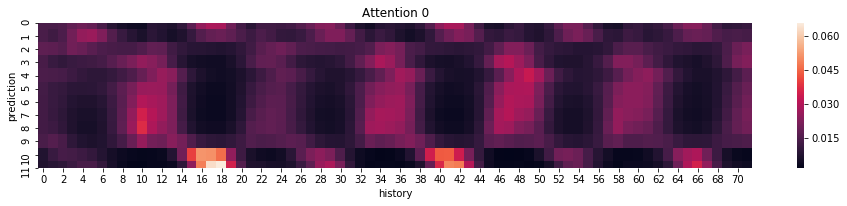

In [33]:
pred_idx = 200
enc_x = torch.tensor(series[pred_idx - enc_lens: pred_idx]).unsqueeze(0).float()
cat_x = torch.tensor(month[pred_idx-enc_lens: pred_idx + dec_lens]).unsqueeze(0).unsqueeze(2).long()
y_pred, attns = model.predict(enc_x, dec_lens, category_x=cat_x, use_move_scale=True, return_attns=True)
plot_attentions(attns)

Text(0.5, 1.0, 'Seq2Seq 1 Attention prediction')

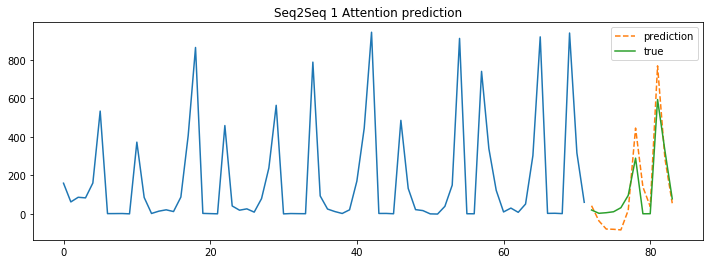

In [34]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Seq2Seq 1 Attention prediction')

## 4. Seq2Seq(Attention 4)

In [8]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 4,
        'use_attn': True,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(100, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.986: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.15it/s]


epoch 1 / 100: train loss 1.081 val loss 1.183 RMSE 180.795
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 1.114: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.20it/s]


epoch 2 / 100: train loss 0.873 val loss 0.957 RMSE 166.934


batch 17 / 17, loss 0.869: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.62it/s]


epoch 3 / 100: train loss 0.798 val loss 0.911 RMSE 162.311


batch 17 / 17, loss 0.716: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.79it/s]


epoch 4 / 100: train loss 0.753 val loss 0.887 RMSE 159.198


batch 17 / 17, loss 0.751: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.56it/s]


epoch 5 / 100: train loss 0.738 val loss 0.883 RMSE 158.574


batch 17 / 17, loss 0.851: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.57it/s]


epoch 6 / 100: train loss 0.730 val loss 0.864 RMSE 155.286


batch 17 / 17, loss 0.615: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.65it/s]


epoch 7 / 100: train loss 0.683 val loss 0.811 RMSE 151.369


batch 17 / 17, loss 0.714: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.26it/s]


epoch 8 / 100: train loss 0.646 val loss 0.796 RMSE 149.548


batch 17 / 17, loss 0.776: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.62it/s]


epoch 9 / 100: train loss 0.629 val loss 0.820 RMSE 151.504


batch 17 / 17, loss 0.512: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.64it/s]


epoch 10 / 100: train loss 0.604 val loss 0.794 RMSE 150.396


batch 17 / 17, loss 0.629: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.60it/s]


epoch 11 / 100: train loss 0.580 val loss 0.747 RMSE 145.236


batch 17 / 17, loss 0.492: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.06it/s]


epoch 12 / 100: train loss 0.555 val loss 0.794 RMSE 149.759


batch 17 / 17, loss 0.532: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.68it/s]


epoch 13 / 100: train loss 0.552 val loss 0.746 RMSE 144.990


batch 17 / 17, loss 0.584: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.31it/s]


epoch 14 / 100: train loss 0.568 val loss 0.733 RMSE 143.232


batch 17 / 17, loss 0.383: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.35it/s]


epoch 15 / 100: train loss 0.502 val loss 0.729 RMSE 143.901


batch 17 / 17, loss 0.513: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.03it/s]


epoch 16 / 100: train loss 0.496 val loss 0.693 RMSE 137.915


batch 17 / 17, loss 0.474: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.08it/s]


epoch 17 / 100: train loss 0.476 val loss 0.694 RMSE 137.736


batch 17 / 17, loss 0.565: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.25it/s]


epoch 18 / 100: train loss 0.461 val loss 0.725 RMSE 143.736


batch 17 / 17, loss 0.502: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.92it/s]


epoch 19 / 100: train loss 0.450 val loss 0.659 RMSE 135.402


batch 17 / 17, loss 0.332: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.14it/s]


epoch 20 / 100: train loss 0.414 val loss 0.635 RMSE 132.939


batch 17 / 17, loss 0.484: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.95it/s]


epoch 21 / 100: train loss 0.394 val loss 0.611 RMSE 129.459


batch 17 / 17, loss 0.443: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.56it/s]


epoch 22 / 100: train loss 0.424 val loss 0.624 RMSE 132.078


batch 17 / 17, loss 0.395: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 23 / 100: train loss 0.403 val loss 0.600 RMSE 126.605


batch 17 / 17, loss 0.433: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.99it/s]


epoch 24 / 100: train loss 0.375 val loss 0.605 RMSE 127.686


batch 17 / 17, loss 0.291: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.17it/s]


epoch 25 / 100: train loss 0.360 val loss 0.625 RMSE 131.914


batch 17 / 17, loss 0.242: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.28it/s]


epoch 26 / 100: train loss 0.335 val loss 0.605 RMSE 127.883


batch 17 / 17, loss 0.282: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.83it/s]


epoch 27 / 100: train loss 0.349 val loss 0.607 RMSE 127.670


batch 17 / 17, loss 0.401: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.68it/s]


epoch 28 / 100: train loss 0.360 val loss 0.608 RMSE 127.545


batch 17 / 17, loss 0.296: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.11it/s]


epoch 29 / 100: train loss 0.325 val loss 0.545 RMSE 118.697


batch 17 / 17, loss 0.401: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.49it/s]


epoch 30 / 100: train loss 0.320 val loss 0.524 RMSE 116.847


batch 17 / 17, loss 0.253: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.85it/s]


epoch 31 / 100: train loss 0.296 val loss 0.525 RMSE 115.908


batch 17 / 17, loss 0.245: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.56it/s]


epoch 32 / 100: train loss 0.292 val loss 0.501 RMSE 112.415


batch 17 / 17, loss 0.285: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 33 / 100: train loss 0.272 val loss 0.500 RMSE 112.036


batch 17 / 17, loss 0.346: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.20it/s]


epoch 34 / 100: train loss 0.257 val loss 0.486 RMSE 110.195


batch 17 / 17, loss 0.221: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.24it/s]


epoch 35 / 100: train loss 0.246 val loss 0.487 RMSE 109.684


batch 17 / 17, loss 0.241: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.94it/s]


epoch 36 / 100: train loss 0.253 val loss 0.483 RMSE 108.292


batch 17 / 17, loss 0.207: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.74it/s]


epoch 37 / 100: train loss 0.243 val loss 0.464 RMSE 107.141


batch 17 / 17, loss 0.289: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.90it/s]


epoch 38 / 100: train loss 0.238 val loss 0.468 RMSE 106.413


batch 17 / 17, loss 0.227: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.71it/s]


epoch 39 / 100: train loss 0.238 val loss 0.459 RMSE 104.915


batch 17 / 17, loss 0.199: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.10it/s]


epoch 40 / 100: train loss 0.226 val loss 0.449 RMSE 103.592


batch 17 / 17, loss 0.207: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.82it/s]


epoch 41 / 100: train loss 0.226 val loss 0.457 RMSE 103.854


batch 17 / 17, loss 0.173: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.76it/s]


epoch 42 / 100: train loss 0.217 val loss 0.437 RMSE 101.884


batch 17 / 17, loss 0.180: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.55it/s]


epoch 43 / 100: train loss 0.217 val loss 0.431 RMSE 100.788


batch 17 / 17, loss 0.243: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.83it/s]


epoch 44 / 100: train loss 0.217 val loss 0.430 RMSE 100.464


batch 17 / 17, loss 0.176: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.32it/s]


epoch 45 / 100: train loss 0.202 val loss 0.436 RMSE 100.704


batch 17 / 17, loss 0.183: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 46 / 100: train loss 0.209 val loss 0.423 RMSE 99.478


batch 17 / 17, loss 0.175: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.54it/s]


epoch 47 / 100: train loss 0.207 val loss 0.423 RMSE 99.166


batch 17 / 17, loss 0.367: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.70it/s]


epoch 48 / 100: train loss 0.210 val loss 0.422 RMSE 99.142


batch 17 / 17, loss 0.204: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.95it/s]


epoch 49 / 100: train loss 0.199 val loss 0.422 RMSE 99.057


batch 17 / 17, loss 0.197: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.09it/s]


epoch 50 / 100: train loss 0.200 val loss 0.421 RMSE 98.896


batch 17 / 17, loss 0.182: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.07it/s]


epoch 51 / 100: train loss 0.196 val loss 0.421 RMSE 98.821


batch 17 / 17, loss 0.188: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.65it/s]


epoch 52 / 100: train loss 0.201 val loss 0.420 RMSE 98.573


batch 17 / 17, loss 0.161: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 53 / 100: train loss 0.202 val loss 0.420 RMSE 98.534


batch 17 / 17, loss 0.457: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.23it/s]


epoch 54 / 100: train loss 0.208 val loss 0.420 RMSE 98.555


batch 17 / 17, loss 0.167: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.57it/s]


epoch 55 / 100: train loss 0.205 val loss 0.419 RMSE 98.551


batch 17 / 17, loss 0.246: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.88it/s]


epoch 56 / 100: train loss 0.225 val loss 0.467 RMSE 107.090


batch 17 / 17, loss 0.385: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.85it/s]


epoch 57 / 100: train loss 0.279 val loss 0.521 RMSE 114.583


batch 17 / 17, loss 0.236: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.86it/s]


epoch 58 / 100: train loss 0.288 val loss 0.532 RMSE 117.220


batch 17 / 17, loss 0.508: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.69it/s]


epoch 59 / 100: train loss 0.265 val loss 0.638 RMSE 133.585


batch 17 / 17, loss 0.304: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.60it/s]


epoch 60 / 100: train loss 0.312 val loss 0.458 RMSE 106.661


batch 17 / 17, loss 0.189: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.24it/s]


epoch 61 / 100: train loss 0.239 val loss 0.420 RMSE 100.615


batch 17 / 17, loss 0.170: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.74it/s]


epoch 62 / 100: train loss 0.198 val loss 0.399 RMSE 95.814


batch 17 / 17, loss 0.127: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.99it/s]


epoch 63 / 100: train loss 0.175 val loss 0.412 RMSE 98.838


batch 17 / 17, loss 0.202: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.06it/s]


epoch 64 / 100: train loss 0.169 val loss 0.340 RMSE 86.866


batch 17 / 17, loss 0.122: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.78it/s]


epoch 65 / 100: train loss 0.149 val loss 0.312 RMSE 82.879


batch 17 / 17, loss 0.133: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.95it/s]


epoch 66 / 100: train loss 0.140 val loss 0.298 RMSE 80.921


batch 17 / 17, loss 0.158: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.22it/s]


epoch 67 / 100: train loss 0.132 val loss 0.292 RMSE 79.905


batch 17 / 17, loss 0.100: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.22it/s]


epoch 68 / 100: train loss 0.123 val loss 0.396 RMSE 101.531


batch 17 / 17, loss 0.112: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.01it/s]


epoch 69 / 100: train loss 0.150 val loss 0.291 RMSE 80.180


batch 17 / 17, loss 0.115: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.29it/s]


epoch 70 / 100: train loss 0.126 val loss 0.285 RMSE 77.548


batch 17 / 17, loss 0.109: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.48it/s]


epoch 71 / 100: train loss 0.111 val loss 0.271 RMSE 72.954


batch 17 / 17, loss 0.163: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.62it/s]


epoch 72 / 100: train loss 0.107 val loss 0.270 RMSE 72.137


batch 17 / 17, loss 0.105: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.77it/s]


epoch 73 / 100: train loss 0.103 val loss 0.269 RMSE 69.874


batch 17 / 17, loss 0.082: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.82it/s]


epoch 74 / 100: train loss 0.097 val loss 0.259 RMSE 68.735


batch 17 / 17, loss 0.066: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.95it/s]


epoch 75 / 100: train loss 0.088 val loss 0.254 RMSE 66.665


batch 17 / 17, loss 0.090: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.58it/s]


epoch 76 / 100: train loss 0.086 val loss 0.242 RMSE 64.566


batch 17 / 17, loss 0.090: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.24it/s]


epoch 77 / 100: train loss 0.086 val loss 0.234 RMSE 65.146


batch 17 / 17, loss 0.081: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.10it/s]


epoch 78 / 100: train loss 0.084 val loss 0.242 RMSE 64.772


batch 17 / 17, loss 0.076: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 79 / 100: train loss 0.084 val loss 0.248 RMSE 66.450


batch 17 / 17, loss 0.066: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.88it/s]


epoch 80 / 100: train loss 0.084 val loss 0.263 RMSE 65.424


batch 17 / 17, loss 0.063: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.30it/s]


epoch 81 / 100: train loss 0.075 val loss 0.228 RMSE 61.617


batch 17 / 17, loss 0.098: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.72it/s]


epoch 82 / 100: train loss 0.130 val loss 0.297 RMSE 81.428


batch 17 / 17, loss 0.098: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.78it/s]


epoch 83 / 100: train loss 0.114 val loss 0.256 RMSE 72.360


batch 17 / 17, loss 0.085: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.42it/s]


epoch 84 / 100: train loss 0.098 val loss 0.237 RMSE 66.189


batch 17 / 17, loss 0.073: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.47it/s]


epoch 85 / 100: train loss 0.091 val loss 0.214 RMSE 61.026


batch 17 / 17, loss 0.061: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 86 / 100: train loss 0.074 val loss 0.204 RMSE 57.516


batch 17 / 17, loss 0.063: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.30it/s]


epoch 87 / 100: train loss 0.068 val loss 0.227 RMSE 58.452


batch 17 / 17, loss 0.047: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.71it/s]


epoch 88 / 100: train loss 0.063 val loss 0.216 RMSE 56.508


batch 17 / 17, loss 0.051: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.99it/s]


epoch 89 / 100: train loss 0.060 val loss 0.221 RMSE 56.136


batch 17 / 17, loss 0.056: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.31it/s]


epoch 90 / 100: train loss 0.060 val loss 0.216 RMSE 54.332


batch 17 / 17, loss 0.055: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.65it/s]


epoch 91 / 100: train loss 0.058 val loss 0.219 RMSE 55.523


batch 17 / 17, loss 0.050: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.92it/s]


epoch 92 / 100: train loss 0.056 val loss 0.213 RMSE 55.691


batch 17 / 17, loss 0.040: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.56it/s]


epoch 93 / 100: train loss 0.055 val loss 0.200 RMSE 52.101


batch 17 / 17, loss 0.053: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.56it/s]


epoch 94 / 100: train loss 0.055 val loss 0.200 RMSE 51.390


batch 17 / 17, loss 0.053: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.70it/s]


epoch 95 / 100: train loss 0.055 val loss 0.194 RMSE 51.210


batch 17 / 17, loss 0.048: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.92it/s]


epoch 96 / 100: train loss 0.052 val loss 0.195 RMSE 51.063


batch 17 / 17, loss 0.045: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.76it/s]


epoch 97 / 100: train loss 0.050 val loss 0.177 RMSE 48.800


batch 17 / 17, loss 0.093: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.84it/s]


epoch 98 / 100: train loss 0.052 val loss 0.181 RMSE 49.213


batch 17 / 17, loss 0.050: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.97it/s]


epoch 99 / 100: train loss 0.050 val loss 0.201 RMSE 50.607


batch 17 / 17, loss 0.045: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.82it/s]


epoch 100 / 100: train loss 0.049 val loss 0.179 RMSE 49.249
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_97_0.177.pkl


In [11]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\evilp\\project\\Deep-Time-Series-Prediction\\notebooks\\logs\\Seq2Seq_epoch_97_0.177.pkl'

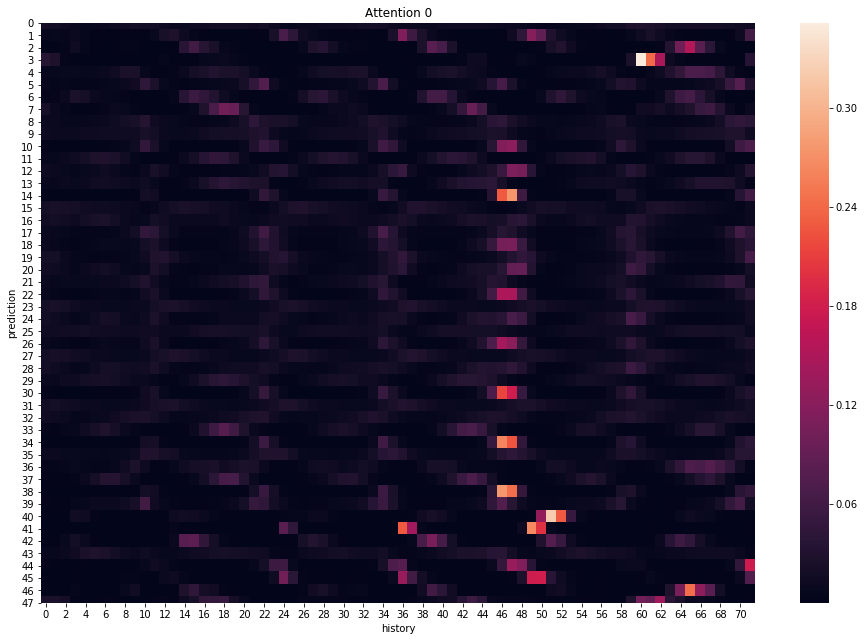

In [12]:
pred_idx = 200
enc_x = torch.tensor(series[pred_idx - enc_lens: pred_idx]).unsqueeze(0).float()
cat_x = torch.tensor(month[pred_idx-enc_lens: pred_idx + dec_lens]).unsqueeze(0).unsqueeze(2).long()
y_pred, attns = model.predict(enc_x, dec_lens, category_x=cat_x, use_move_scale=True, return_attns=True)
plot_attentions(attns)

Text(0.5, 1.0, 'Seq2Seq 4 Attention prediction')

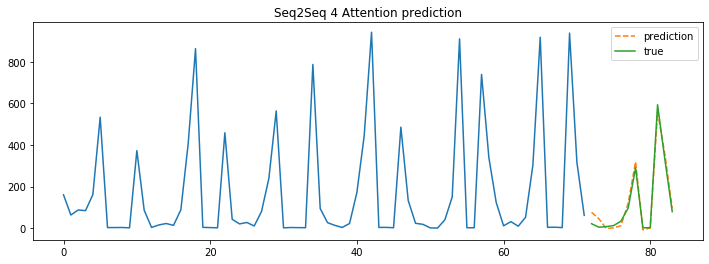

In [13]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Seq2Seq 4 Attention prediction')

## 5. Simple WaveNet

In [6]:
dataset = SimpleWaveNetDataSet(series, enc_lens, dec_lens)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [7]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'dilation': [1, 2, 4, 8, 16, 32, 64],
        'dropout': 0.2,
        'residual_channels': 72,
        'teacher_forcing_rate': 0.5,
        'use_move_scale': True,
    }

compile_params = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
    'loss_fn': 'MSELoss',
}

In [8]:
model = SimpleWaveNet(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.944: 100%|██████████| 17/17 [00:01<00:00,  9.32it/s]


epoch 1 / 50: train loss 1.068 val loss 1.187 RMSE 180.704
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.737: 100%|██████████| 17/17 [00:01<00:00,  9.63it/s]


epoch 2 / 50: train loss 0.913 val loss 1.026 RMSE 169.131


batch 17 / 17, loss 0.653: 100%|██████████| 17/17 [00:01<00:00,  9.48it/s]


epoch 3 / 50: train loss 0.785 val loss 0.875 RMSE 156.222


batch 17 / 17, loss 0.619: 100%|██████████| 17/17 [00:01<00:00,  9.97it/s]


epoch 4 / 50: train loss 0.729 val loss 0.850 RMSE 153.565


batch 17 / 17, loss 0.654: 100%|██████████| 17/17 [00:01<00:00,  9.46it/s]


epoch 5 / 50: train loss 0.720 val loss 0.848 RMSE 153.178


batch 17 / 17, loss 0.742: 100%|██████████| 17/17 [00:01<00:00,  9.70it/s]


epoch 6 / 50: train loss 0.689 val loss 0.837 RMSE 151.413


batch 17 / 17, loss 0.713: 100%|██████████| 17/17 [00:01<00:00,  9.71it/s]


epoch 7 / 50: train loss 0.615 val loss 0.749 RMSE 142.762


batch 17 / 17, loss 0.609: 100%|██████████| 17/17 [00:01<00:00,  9.59it/s]


epoch 8 / 50: train loss 0.558 val loss 0.746 RMSE 141.891


batch 17 / 17, loss 0.455: 100%|██████████| 17/17 [00:01<00:00,  9.56it/s]


epoch 9 / 50: train loss 0.505 val loss 0.712 RMSE 138.075


batch 17 / 17, loss 0.427: 100%|██████████| 17/17 [00:01<00:00,  9.64it/s]


epoch 10 / 50: train loss 0.456 val loss 0.687 RMSE 134.442


batch 17 / 17, loss 0.318: 100%|██████████| 17/17 [00:01<00:00,  9.72it/s]


epoch 11 / 50: train loss 0.414 val loss 0.677 RMSE 131.931


batch 17 / 17, loss 0.369: 100%|██████████| 17/17 [00:01<00:00,  9.73it/s]


epoch 12 / 50: train loss 0.386 val loss 0.651 RMSE 130.122


batch 17 / 17, loss 0.345: 100%|██████████| 17/17 [00:01<00:00,  9.61it/s]


epoch 13 / 50: train loss 0.352 val loss 0.604 RMSE 120.750


batch 17 / 17, loss 0.304: 100%|██████████| 17/17 [00:01<00:00,  9.63it/s]


epoch 14 / 50: train loss 0.326 val loss 0.560 RMSE 116.753


batch 17 / 17, loss 0.228: 100%|██████████| 17/17 [00:01<00:00,  9.81it/s]


epoch 15 / 50: train loss 0.301 val loss 0.536 RMSE 111.938


batch 17 / 17, loss 0.369: 100%|██████████| 17/17 [00:01<00:00,  9.55it/s]


epoch 16 / 50: train loss 0.291 val loss 0.504 RMSE 107.678


batch 17 / 17, loss 0.262: 100%|██████████| 17/17 [00:01<00:00,  9.53it/s]


epoch 17 / 50: train loss 0.279 val loss 0.486 RMSE 106.031


batch 17 / 17, loss 0.235: 100%|██████████| 17/17 [00:01<00:00,  9.47it/s]


epoch 18 / 50: train loss 0.259 val loss 0.435 RMSE 98.015


batch 17 / 17, loss 0.206: 100%|██████████| 17/17 [00:01<00:00,  9.64it/s]


epoch 19 / 50: train loss 0.252 val loss 0.438 RMSE 97.462


batch 17 / 17, loss 0.380: 100%|██████████| 17/17 [00:01<00:00,  9.54it/s]


epoch 20 / 50: train loss 0.248 val loss 0.438 RMSE 97.261


batch 17 / 17, loss 0.202: 100%|██████████| 17/17 [00:01<00:00,  9.71it/s]


epoch 21 / 50: train loss 0.234 val loss 0.388 RMSE 89.605


batch 17 / 17, loss 0.222: 100%|██████████| 17/17 [00:01<00:00,  9.64it/s]


epoch 22 / 50: train loss 0.224 val loss 0.402 RMSE 92.663


batch 17 / 17, loss 0.161: 100%|██████████| 17/17 [00:01<00:00,  9.45it/s]


epoch 23 / 50: train loss 0.222 val loss 0.384 RMSE 88.312


batch 17 / 17, loss 0.148: 100%|██████████| 17/17 [00:01<00:00,  9.62it/s]


epoch 24 / 50: train loss 0.213 val loss 0.371 RMSE 86.307


batch 17 / 17, loss 0.159: 100%|██████████| 17/17 [00:01<00:00,  9.67it/s]


epoch 25 / 50: train loss 0.215 val loss 0.354 RMSE 85.687


batch 17 / 17, loss 0.193: 100%|██████████| 17/17 [00:01<00:00,  9.75it/s]


epoch 26 / 50: train loss 0.209 val loss 0.351 RMSE 83.648


batch 17 / 17, loss 0.185: 100%|██████████| 17/17 [00:01<00:00,  9.60it/s]


epoch 27 / 50: train loss 0.200 val loss 0.329 RMSE 80.128


batch 17 / 17, loss 0.178: 100%|██████████| 17/17 [00:01<00:00,  9.71it/s]


epoch 28 / 50: train loss 0.207 val loss 0.327 RMSE 80.740


batch 17 / 17, loss 0.210: 100%|██████████| 17/17 [00:01<00:00,  9.65it/s]


epoch 29 / 50: train loss 0.199 val loss 0.302 RMSE 78.812


batch 17 / 17, loss 0.184: 100%|██████████| 17/17 [00:01<00:00,  9.78it/s]


epoch 30 / 50: train loss 0.196 val loss 0.324 RMSE 81.929


batch 17 / 17, loss 0.279: 100%|██████████| 17/17 [00:01<00:00,  9.87it/s]


epoch 31 / 50: train loss 0.197 val loss 0.292 RMSE 78.894


batch 17 / 17, loss 0.192: 100%|██████████| 17/17 [00:01<00:00,  9.66it/s]


epoch 32 / 50: train loss 0.194 val loss 0.290 RMSE 77.234


batch 17 / 17, loss 0.210: 100%|██████████| 17/17 [00:01<00:00,  9.68it/s]


epoch 33 / 50: train loss 0.193 val loss 0.311 RMSE 81.627


batch 17 / 17, loss 0.179: 100%|██████████| 17/17 [00:01<00:00,  9.60it/s]


epoch 34 / 50: train loss 0.185 val loss 0.281 RMSE 75.366


batch 17 / 17, loss 0.190: 100%|██████████| 17/17 [00:01<00:00,  9.67it/s]


epoch 35 / 50: train loss 0.188 val loss 0.271 RMSE 73.677


batch 17 / 17, loss 0.153: 100%|██████████| 17/17 [00:01<00:00,  9.73it/s]


epoch 36 / 50: train loss 0.175 val loss 0.260 RMSE 73.120


batch 17 / 17, loss 0.211: 100%|██████████| 17/17 [00:01<00:00,  9.88it/s]


epoch 37 / 50: train loss 0.182 val loss 0.270 RMSE 73.501


batch 17 / 17, loss 0.189: 100%|██████████| 17/17 [00:01<00:00,  9.89it/s]


epoch 38 / 50: train loss 0.180 val loss 0.249 RMSE 71.581


batch 17 / 17, loss 0.202: 100%|██████████| 17/17 [00:01<00:00,  9.69it/s]


epoch 39 / 50: train loss 0.177 val loss 0.259 RMSE 72.289


batch 17 / 17, loss 0.240: 100%|██████████| 17/17 [00:01<00:00,  9.73it/s]


epoch 40 / 50: train loss 0.182 val loss 0.264 RMSE 72.682


batch 17 / 17, loss 0.178: 100%|██████████| 17/17 [00:01<00:00, 10.01it/s]


epoch 41 / 50: train loss 0.179 val loss 0.251 RMSE 72.006


batch 17 / 17, loss 0.176: 100%|██████████| 17/17 [00:01<00:00,  9.78it/s]


epoch 42 / 50: train loss 0.180 val loss 0.249 RMSE 71.054


batch 17 / 17, loss 0.169: 100%|██████████| 17/17 [00:01<00:00,  9.68it/s]


epoch 43 / 50: train loss 0.172 val loss 0.250 RMSE 71.930


batch 17 / 17, loss 0.159: 100%|██████████| 17/17 [00:01<00:00,  9.64it/s]


epoch 44 / 50: train loss 0.177 val loss 0.250 RMSE 72.189


batch 17 / 17, loss 0.295: 100%|██████████| 17/17 [00:01<00:00,  9.68it/s]


epoch 45 / 50: train loss 0.181 val loss 0.244 RMSE 69.828


batch 17 / 17, loss 0.164: 100%|██████████| 17/17 [00:01<00:00,  9.21it/s]


epoch 46 / 50: train loss 0.173 val loss 0.245 RMSE 70.611


batch 17 / 17, loss 0.146: 100%|██████████| 17/17 [00:01<00:00,  9.75it/s]


epoch 47 / 50: train loss 0.172 val loss 0.240 RMSE 69.719


batch 17 / 17, loss 0.155: 100%|██████████| 17/17 [00:01<00:00,  9.29it/s]


epoch 48 / 50: train loss 0.173 val loss 0.238 RMSE 69.436


batch 17 / 17, loss 0.126: 100%|██████████| 17/17 [00:01<00:00,  9.59it/s]


epoch 49 / 50: train loss 0.170 val loss 0.235 RMSE 69.052


batch 17 / 17, loss 0.167: 100%|██████████| 17/17 [00:01<00:00,  9.84it/s]


epoch 50 / 50: train loss 0.176 val loss 0.235 RMSE 68.951
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\SimpleWaveNet_epoch_49_0.235.pkl


In [9]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f} '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f} '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f} '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.093 valid loss: 0.235 test loss :0.353 test RMSE :84.691, 


In [10]:
val_set[0].keys()

dict_keys(['enc_inputs', 'dec_outputs'])

Text(0.5, 1.0, 'Simple WaveNet prediction')

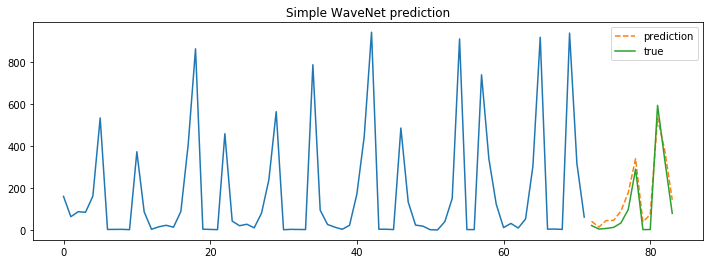

In [22]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[1]
pred = model.predict(enc_inputs, dec_step, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[h], pred[h], dec_outputs[h])
plt.title('Simple WaveNet prediction')

## 6. Summary

| model | num of attention | RMSE(test) | loss(test) | loss(val) | loss(train)|
|:-:| :-: | :-:| :-:| :-:| :-:|
| SimpleSeq2Seq | / | 141.54 | 0.725|0.682|0.476|
| Seq2Seq| 0| 120.7| 0.571| 0.491| 0.279|
| Seq2Seq| 1| 113.9| 0.532| 0.427| 0.222|
| Seq2Seq| 4| 69.5 | 0.534| 0.422| 0.192|
| SimpleWaveNet| / | 84.5 | 0.355 | 0.237| 0.093|